In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
df = pd.read_csv("data/revenue_ab_test.csv")
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.shape

(10000, 3)

In [4]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

With 10,000 entries, we see in this cell that there are only 6,324 unique user ID values. This means that there are multiple entries for certain users in the dataset. First, we aim to combine all of this data under a singular row.

In [5]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

No null values in the data so we can proceed towards combing through the data.

In [6]:
df.sort_values(by=['USER_ID'])

,USER_ID,VARIANT_NAME,REVENUE
2406,2,control,0.0
3479,2,control,0.0
7076,2,control,0.0
7409,3,variant,0.0
4145,3,variant,0.0
...,...,...,...
2998,9996,control,0.0
1064,9998,control,0.0
8970,10000,variant,0.0
8921,10000,control,0.0


We see that there are multiple rows for certain user IDs. Since we don't aim to omit any data, we merely combine the data on the basis of their User IDs and their group type.

In [7]:
final_df = df.groupby(['USER_ID', 'VARIANT_NAME'])['REVENUE'].apply(np.sum).reset_index().sort_values(by='USER_ID')
final_df.shape

(7865, 3)

We managed to reduce the size of the dataset from 10,000 to 7,865. This means that quite a few users were also part of both groups.

In [8]:
df_control = final_df.loc[final_df['VARIANT_NAME'] == 'control']
df_variant = final_df.loc[final_df['VARIANT_NAME'] == 'variant']

In [9]:
df_control.shape

(3931, 3)

In [10]:
df_variant.shape

(3934, 3)

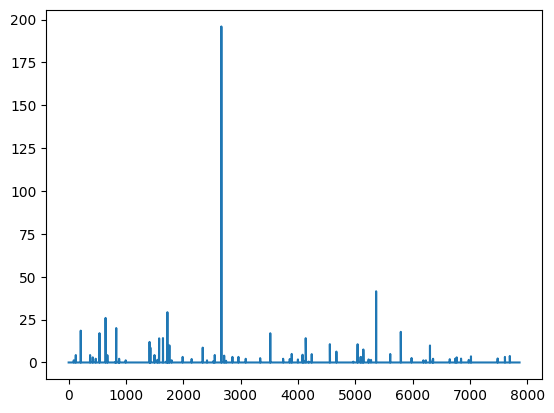

In [11]:
plt.plot(df_control["REVENUE"])

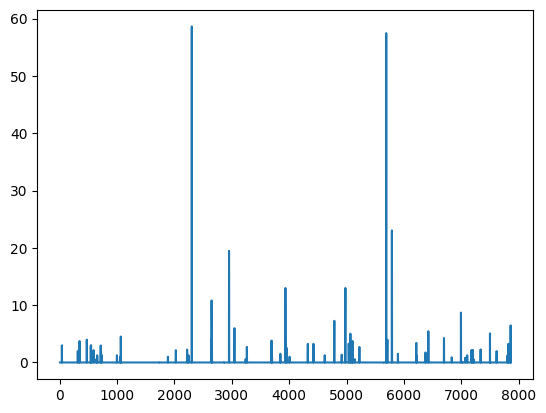

In [12]:
plt.plot(df_variant["REVENUE"])

Both the control and variant groups, with close to 4000 data points each, can be said to approximately follow the Gaussian Distribution (by the Central Limit Theorem). As a result, we can try to identify the results of the experiment using a t-test.

In [13]:
#We don't care about user ID, so we describe only the revenue.
df_control.describe()["REVENUE"]

count    3931.000000
mean        0.163572
std         3.385721
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

In [14]:
df_variant.describe()["REVENUE"]

count    3934.000000
mean        0.089342
std         1.484566
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        58.630000
Name: REVENUE, dtype: float64

In [15]:
control_rev = df_control["REVENUE"]
variant_rev = df_variant["REVENUE"]

In [16]:
print(np.var(control_rev), np.var(variant_rev))

11.460192891017975 2.2033749351397702


We can see that the variances of both of these groups have a ratio of 11:2 (Approximately 5.5:1). As a result, Student's t-test cannot be applied to this dataset. We use Welch's two-sample hypothesis t-test testing the following hypotheses:
H<sub>0</sub>: There is no significance difference in the sample means of both the test groups
H<sub>1</sub>: There is a significance difference in the sample means of both the test groups
We assume a significance interval of 5%.

In [17]:
result = stats.ttest_ind(control_rev, variant_rev, equal_var=False)

In [18]:
result

Ttest_indResult(statistic=1.2589840631023705, pvalue=0.20809064618700338)

We can see that the p-value of the above test is 0.2, which is greater than our assumed significance interval of 0.05. Due to the robustness of the Welch t-test when it comes to Type I errors, we can accept the null hypothesis and conclude that there is a lack of significant revenue increase with the newer revenue system. However, nothing can be concluded on the effectiveness of the new system in a vacuum and any judgement should be not be taken until further data is available.